## 1.  Install beta version of TF 2.0

In [3]:
%pip install -U --pre tensorflow


     |████████████████████████████████| 87.9MB 1.2MB/s 
     |████████████████████████████████| 501kB 38.1MB/s 
     |████████████████████████████████| 3.1MB 33.5MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [4]:
%pip install tfds-nightly

In [12]:
import tensorflow as tf

print(tf.__version__)

2.0.0-beta1


## 2. Tensorflow 2.0 Dataset API

In [51]:
import tensorflow_datasets as tfds

print(tfds.list_builders())

['abstract_reasoning', 'amazon_us_reviews', 'bair_robot_pushing_small', 'bigearthnet', 'binarized_mnist', 'binary_alpha_digits', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_corrupted', 'clevr', 'cnn_dailymail', 'coco', 'coco2014', 'colorectal_histology', 'colorectal_histology_large', 'curated_breast_imaging_ddsm', 'cycle_gan', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'downsampled_imagenet', 'dsprites', 'dtd', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'eurosat', 'fashion_mnist', 'flores', 'food101', 'glue', 'groove', 'higgs', 'horses_or_humans', 'image_label_folder', 'imagenet2012', 'imagenet2012_corrupted', 'imdb_reviews', 'iris', 'kitti', 'kmnist', 'lm1b', 'lsun', 'mnist', 'mnist_corrupted', 'moving_mnist', 'multi_nli', 'nsynth', 'omniglot', 'open_images_v4', 'oxford_flowers102', 'oxford_iiit_pet', 'para_crawl', 'patch_camelyon', 'pet_finder', 'quic

In [0]:
train_test_splits = (8, 1, 1)

splits = tfds.Split.TRAIN.subsplit(weighted=train_test_splits)

(raw_train, raw_validation, raw_test), metadata = tfds.load(name="tf_flowers", with_info=True, split=list(splits), as_supervised=True)

# specifying batch_size=-1 will load full dataset in the memory
# as_supervised: `bool`, if `True`, the returned `tf.data.Dataset`
# will have a 2-tuple structure `(input, label)`

## 3. Preprocessing dataset

In [0]:
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def format_example(image, label):
  
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [54]:
print(metadata)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    urls=['http://download.tensorflow.org/example_images/flower_photos.tgz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



## 4. Shuffling dataset

In [55]:
SHUFFLE_BUFFER_SIZE = 1024
BATCH_SIZE = 32

train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation = validation.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
# (Optional) prefetch will enable the input pipeline to asynchronously fetch batches while
# your model is training.
train = train.prefetch(tf.data.experimental.AUTOTUNE)
print(train)
print(validation)
print(test)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>


## 5. Data augmentations

In [56]:
def augment_data(image, label):
  
  print("Augment data called!")
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  # Add more augmentation of your choice
  return image, label

train = raw_train.map(augment_data)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

Augment data called!


## 6. Visualization dataset

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
tfds.as_numpy(train)

<generator object _eager_dataset_iterator at 0x7fea8bd56b48>

In [0]:
get_label_name = metadata.features['label'].int2str

In [60]:
plt.figure(figsize=(12,12)) 
count=0
for batch in tfds.as_numpy(train):
    image, label = batch[0], batch[1]
    count+=1
for i in range(9):
    image, label = batch[0][i], batch[1][i]
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.grid(False)
print(count)
print(type(image))
print(image.shape)
print(type(label))
print(label.shape)

IndexError: ignored

<Figure size 864x864 with 0 Axes>

In [0]:
# Creating a simple CNN model in keras using functional API
def create_model():
  
    img_inputs = keras.Input(shape=IMG_SHAPE)
    conv_1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool_2)
    flatten = keras.layers.Flatten()(conv_3)
    dense_1 = keras.layers.Dense(64, activation='relu')(flatten)
    output = keras.layers.Dense(metadata.features['label'].num_classes, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)
    
    return model

In [62]:
simple_model = create_model()
simple_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0   

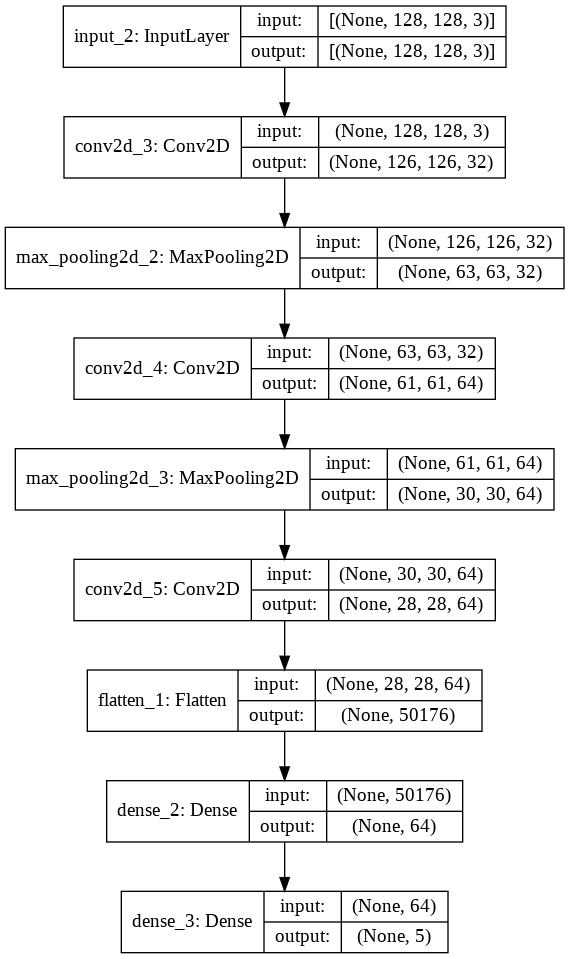

In [63]:
keras.utils.plot_model(simple_model, 'flower_model_with_shape_info.png', show_shapes=True)

In [0]:
import datetime, os

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir)

In [65]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples * weight/10 for weight in train_test_splits
)

steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = round(num_val)//BATCH_SIZE

print('Number of examples in the train set:', num_train)
print('Number of examples in the validation set:', num_val)
print('Number of examples in the test set:', num_test)

Number of examples in the train set: 2936.0
Number of examples in the validation set: 367.0
Number of examples in the test set: 367.0


In [69]:
history = train_model(simple_model)

W0818 15:40:18.010973 140646667224960 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Epoch 1/5


ValueError: ignored